In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np
import gala as ga

import astropy.coordinates as coord
import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()
from astropy.table import Table, join
from astroquery.gaia import Gaia

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [4]:
# read in the table from Zari+2021 and remove badly measured stars
zari = Table.read("../src/data/filtered_sample.fits", hdu=1)
zari = zari[zari["parallax"] > 0.5]

In [5]:
# create coordinate objects for the table and the BH from Sahu+2022
c_zari = coord.SkyCoord(
    ra=zari["ra"] * u.deg,
    dec=zari["dec"] * u.deg,
    distance=coord.Distance(parallax=zari["parallax"] * u.mas),
)

c_BH = coord.SkyCoord(
    ra="17:51:40.2082",
    dec="-29:53:26.502",
    unit=(u.hourangle, u.degree),
    distance=1.58*u.kpc,
)

In [6]:
# shorten table to only nearby stars
matching_zari_table = zari[c_BH.separation_3d(c_zari) < 0.1 * u.kpc]

In [7]:
# start an astroquery job to get all of the matching Gaia data for these stars
j = Gaia.launch_job(
    query="SELECT * FROM gaiaedr3.gaia_source as gaia JOIN tap_upload.zari as zari ON zari.source_id=gaia.source_id",
    upload_resource=matching_zari_table, 
    upload_table_name="zari", verbose=True
)
zari_gaia = j.get_results()

Launched query: 'SELECT  TOP 2000 * FROM gaiaedr3.gaia_source as gaia JOIN tap_upload.zari as zari ON zari.source_id=gaia.source_id'
------>https
host = gea.esac.esa.int:443
context = /tap-server/tap/sync
Content-type = multipart/form-data; boundary====1646081946517===
200 200
[('Date', 'Mon, 28 Feb 2022 20:59:07 GMT'), ('Server', 'Apache/2.4.6 (CentOS) OpenSSL/1.0.2k-fips PHP/5.4.16 mod_jk/1.2.43'), ('Cache-Control', 'no-cache, no-store, max-age=0, must-revalidate'), ('Pragma', 'no-cache'), ('Expires', '0'), ('X-XSS-Protection', '1; mode=block'), ('X-Frame-Options', 'SAMEORIGIN'), ('X-Content-Type-Options', 'nosniff'), ('Set-Cookie', 'JSESSIONID=805C83456BDD670CB252E965E8203699; Path=/tap-server; Secure; HttpOnly'), ('Content-Encoding', 'gzip'), ('Content-Disposition', 'attachment;filename="1646081947268O-result.vot"'), ('Transfer-Encoding', 'chunked'), ('Content-Type', 'application/x-votable+xml')]
Retrieving sync. results...
Query finished.


In [8]:
galcen_frame = coord.Galactocentric()

coords = coord.SkyCoord(
    ra=zari_gaia["ra"],
    dec=zari_gaia["dec"],
    unit=(u.deg, u.deg),
    distance=coord.Distance(parallax=zari_gaia["parallax"].data * u.mas),
    pm_ra_cosdec=zari_gaia["pmra"].data * u.mas/u.yr * np.cos(zari_gaia["dec"].data * u.deg),
    pm_dec=zari_gaia["pmdec"].data * u.mas/u.yr,
    radial_velocity=zari_gaia["dr2_radial_velocity"].data * u.km/u.s
).transform_to(galcen_frame)

In [9]:
w0s = ga.dynamics.PhaseSpacePosition(coords.data)
missing_velocity = np.isnan(coords.v_x.value)

In [10]:
pot = ga.potential.MilkyWayPotential()
orbits = pot.integrate_orbit(w0s[np.logical_not(missing_velocity)], dt=-1 * u.Myr, n_steps=4000)

In [11]:
w0_BH = ga.dynamics.PhaseSpacePosition(coord.SkyCoord(
        ra="17:51:40.2082",
        dec="-29:53:26.502",
        unit=(u.hourangle, u.degree),
        distance=1.58*u.kpc,
        pm_ra_cosdec=-4.36*u.mas/u.yr,# * cosdec,
        pm_dec=3.06*u.mas/u.yr,
        radial_velocity=0*u.km/u.s
    ).transform_to(galcen_frame).data)

In [12]:
orbit_BH = pot.integrate_orbit(w0_BH, dt=-1 * u.Myr, n_steps=4000)

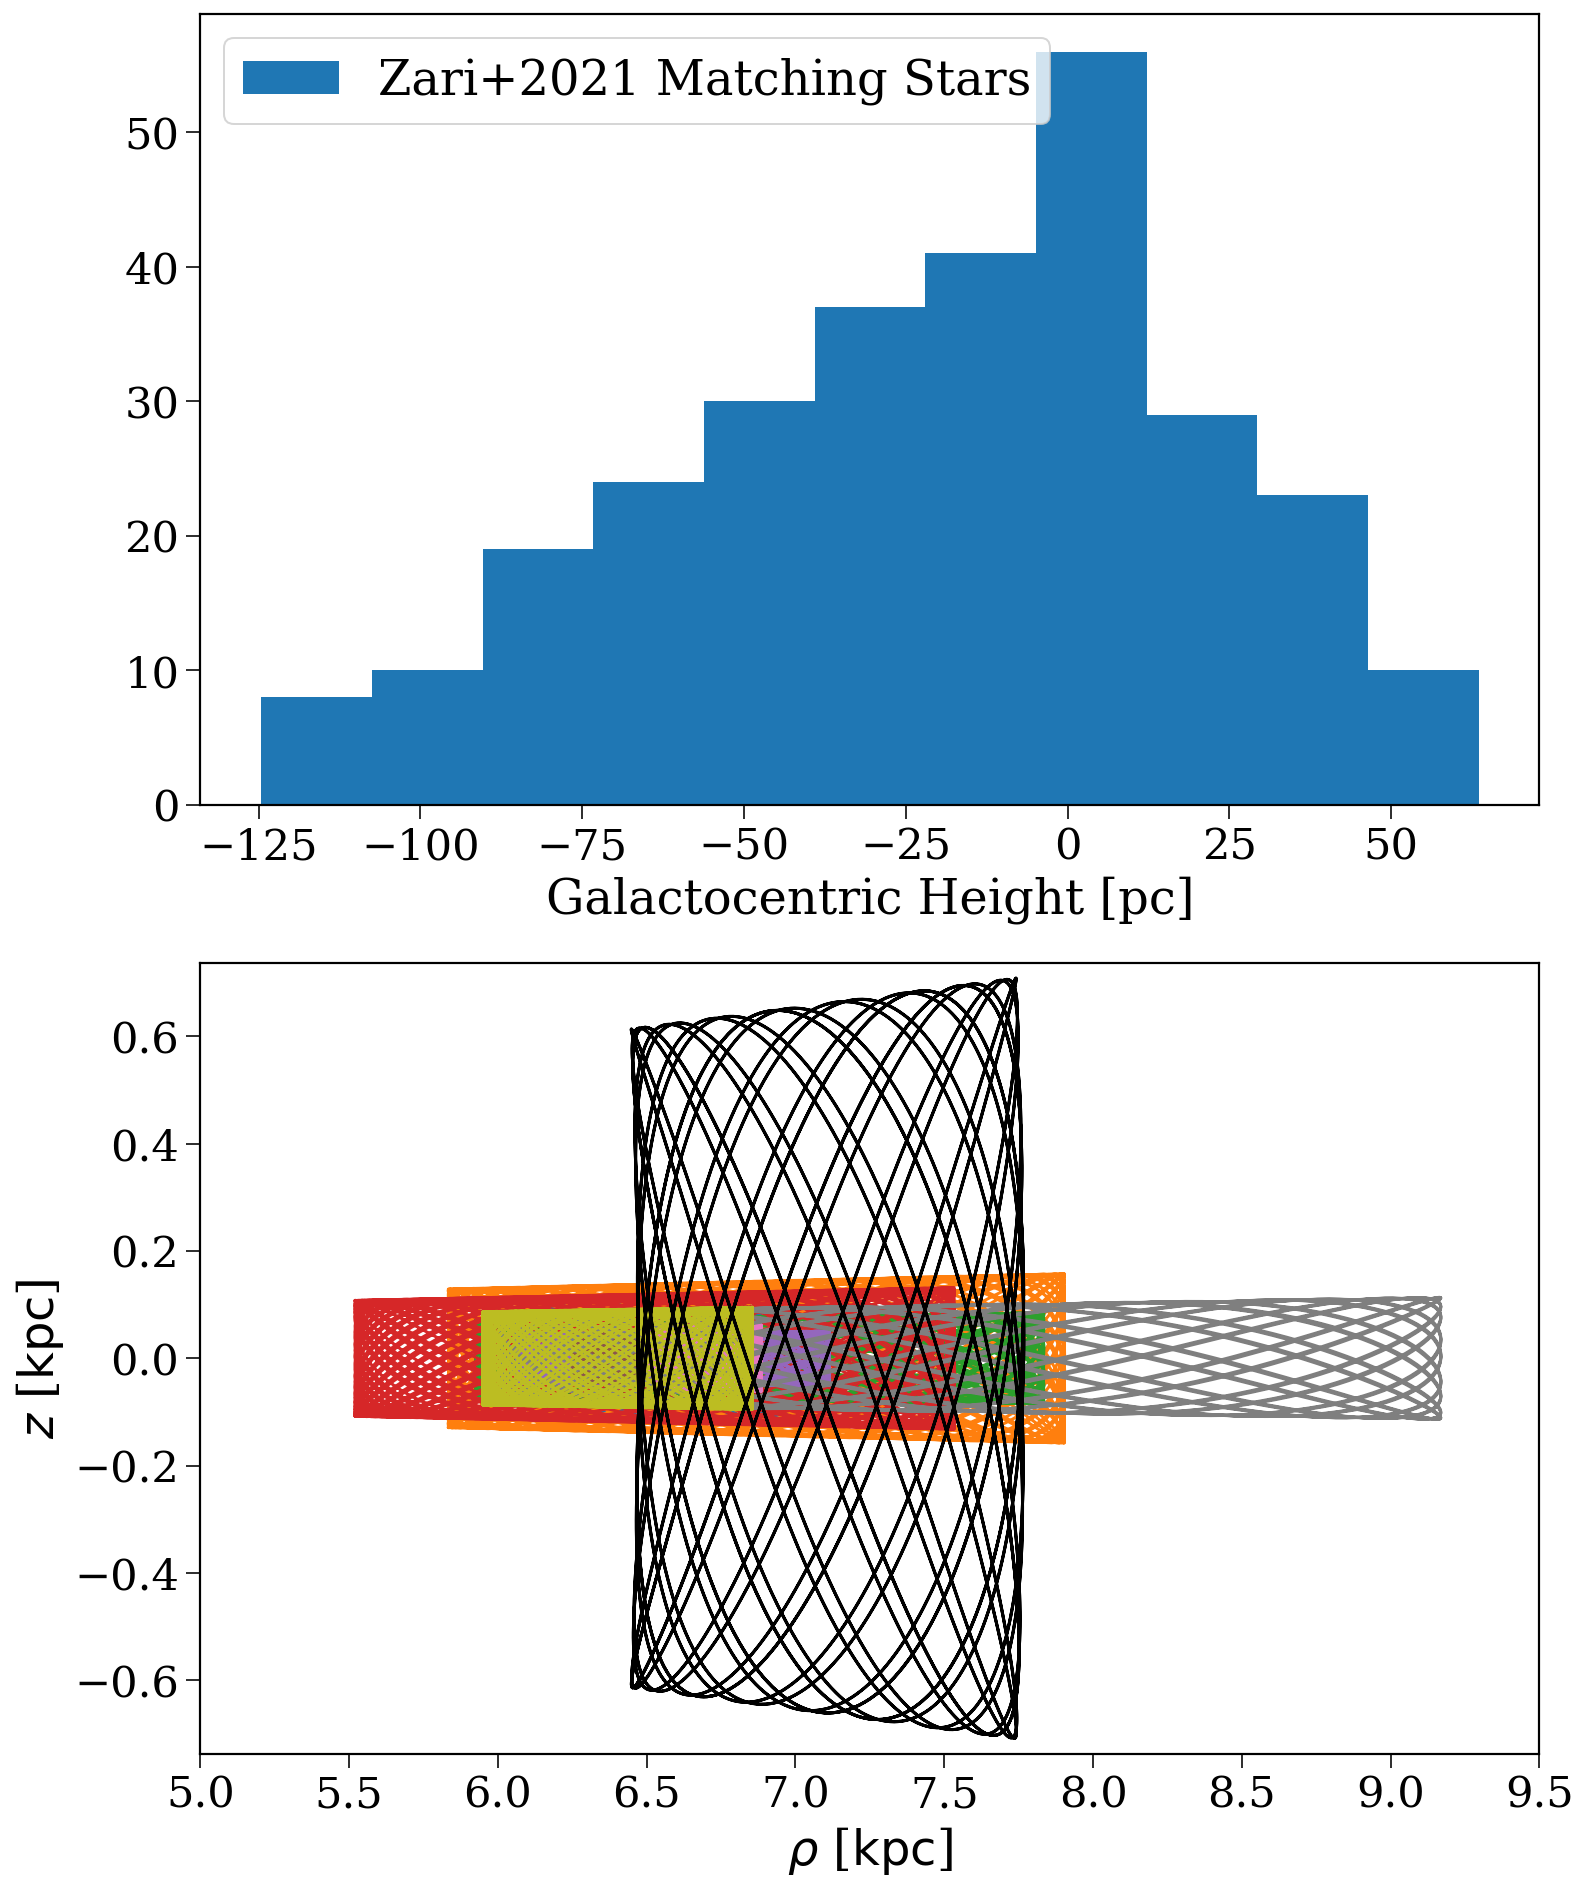

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(12, 16))

axes[0].hist(coords.z.to(u.pc), bins="fd", label="Zari+2021 Matching Stars")

axes[0].set_xlabel("Galactocentric Height [pc]")
axes[0].legend(loc="upper left")

orbits.cylindrical.plot(["rho", "z"], axes=[axes[1]])
orbit_BH.cylindrical.plot(["rho", "z"], axes=[axes[1]], color="black")

axes[1].set_xlim(5, 9.5)

plt.show()